In [1]:
import math
import torch
import pickle
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    rc={"axes.grid": True,
        "grid.linestyle": 'dashed',
        "axes.linewidth": 1.0,
        "axes.facecolor": '1.0',
    }
)

from tqdm import tqdm

def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

def dump_pickle(file, fname):
    with open(fname, "wb") as f:
        pickle.dump(file, f)


In [2]:
from transformers import BertModel, BertTokenizer
encoder = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")     

vocab = list(tokenizer.vocab.keys())
embed = encoder.embeddings.word_embeddings.weight.cpu().detach().numpy()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tmp = dict()
for k, v in zip(vocab, embed): tmp[k] = v 
#keys = tokenizer value = vector embedding

In [4]:
from scipy.spatial.distance import pdist

bert_embeddings = collections.defaultdict(list)

In [5]:
for DIM in tqdm([768]):
    
    embedding = np.array(list(load_pickle(f'bert.{DIM}d.pk').values()))

    bert_distances = collections.defaultdict(list)
    for metric in tqdm(['Manhatten','Euclidean','Minkowski','Chebyshev','Mahalanobis']):
        
        if metric == 'Manhatten':
            
            bert_distances[metric] = pdist(
                embedding, metric='cityblock'
            ).mean()
            
        else:
            
            bert_distances[metric] = pdist(
                embedding, metric=metric.lower()
            ).mean()
        
    bert_embeddings[DIM] = bert_distances

100%|██████████| 1/1 [01:57<00:00, 117.27s/it]


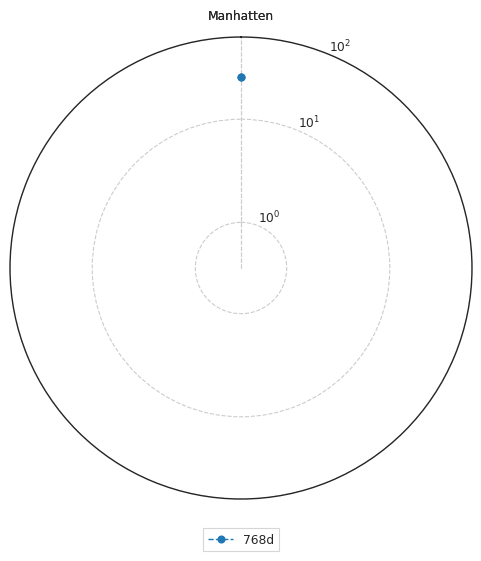

In [6]:
colormap = plt.cm.Blues(np.linspace(0, 1.0, 6))  

for i, (k, v) in enumerate(bert_embeddings.items()):
    
    fig= plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    
    keys = list(v.keys())
    angles = np.linspace(0, 2*np.pi, len(keys), endpoint=False)
    angles = np.concatenate((angles,[angles[0]]))
    
    values = np.array(list(v.values()))
    values = np.concatenate((values,[values[0]]))
    
    ax.plot(angles, values, 'o--', color='tab:blue', linewidth=1)
    ax.fill(angles, values, color='tab:blue', alpha=0.25)
    
    ax.set_ylim([0, 100])
    
    keys = keys + [keys[0]]
    
    ax.set_thetagrids(angles * 180/np.pi, keys, rotation_mode="anchor")
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), keys)
    
    ax.set_rscale('symlog')
    ax.grid(True, which='minor', axis='y')
    
    for label, angle in zip(ax.get_xticklabels(), angles):
      if angle in (0, np.pi):
        label.set_horizontalalignment('center')
      elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
      else:
        label.set_horizontalalignment('right')
    
    plt.gcf()
    plt.legend(
        [f'{k}d'], bbox_to_anchor=(0.5, -0.05),
        fancybox=False, shadow=False, ncol=2,
        loc='upper center'
    )
    
    plt.savefig(f'bert_geometrie_{k}d.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f'bert_geometrie_{k}d.png', format='png', bbox_inches='tight')
    plt.show()